In [ ]:
!pip install transformers
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 786.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00


# Imports

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt
import zipfile


from google.colab.patches import cv2_imshow
from google.colab import drive
from glob import glob
import zipfile
import os
import random
import evaluate
from google.colab import drive

# with zipfile.ZipFile('/content/drive/MyDrive/SPROJ/all_db_fire.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/dataset')

drive.mount('/content/drive')


with zipfile.ZipFile('/content/drive/MyDrive/SPROJ/all_db_fire.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

Mounted at /content/drive


# File Organization

In [ ]:
import os
import shutil

# Source directory where your files are located
source_directory = r"/content/dataset"

# Destination directory where you want to move the files
destination_directory1 =  r"/content/dataset/rgb"
destination_directory2 =  r"/content/dataset/masks"

# Ensure the destination directory exists or create it if not
if not os.path.exists(destination_directory1):
    os.makedirs(destination_directory1)

if not os.path.exists(destination_directory2):
    os.makedirs(destination_directory2)


# Walk through the source directory and find files with 'rgb' in the filename
for root, dirs, files in os.walk(source_directory):
    for file in files:
        if 'rgb' in file:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_directory1, file)

            # Move the file to the destination directory
            shutil.move(source_file_path, destination_file_path)
        if 'gt' in file:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_directory2, file)

            # Move the file to the destination directory
            shutil.move(source_file_path, destination_file_path)




In [ ]:
import os
import random
import shutil

source_x_dir = '/content/dataset/rgb'
source_y_dir = '/content/dataset/masks'
dest_dir = 'data_split'

train_ratio = 0.70
val_ratio = 0.2
test_ratio = 0.1

os.makedirs(dest_dir, exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'train', 'masks'), exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'val', 'masks'), exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(dest_dir, 'test', 'masks'), exist_ok=True)

image_files = os.listdir(source_x_dir)

total_samples = len(image_files)
num_train = int(train_ratio * total_samples)
num_val = int(val_ratio * total_samples)
num_test = total_samples - num_train - num_val

# Shuffle the image files
random.shuffle(image_files)

train_images = image_files[:num_train]
val_images = image_files[num_train:num_train + num_val]
test_images = image_files[num_train + num_val:]

# Function to rename files
def rename_file(old_name, prefix):
    base_name = os.path.splitext(old_name)[0]
    integer_part = base_name.split('_')[0]
    new_name = f"{prefix}_{integer_part}.png"
    return new_name

# Process for train, val, and test datasets
for dataset_type, image_list in [('train', train_images), ('val', val_images), ('test', test_images)]:
    for image_file in image_list:
        if 'rgb' in image_file and 'nir' not in image_file:
            new_image_file = rename_file(image_file, 'image')
            if 'seq' in image_file:
                mask_file = image_file.replace('rgb', 'gt')
            else:
                mask_file = image_file.replace('_rgb.png', '_gt.png')
            new_mask_file = rename_file(mask_file, 'mask')

            shutil.copy(os.path.join(source_x_dir, image_file), os.path.join(dest_dir, dataset_type, 'images', new_image_file))
            shutil.copy(os.path.join(source_y_dir, mask_file), os.path.join(dest_dir, dataset_type, 'masks', new_mask_file))


# Datasets

### Function to read image files

In [ ]:
def load_image_file(image_path, mask_path):
    # print(image_path)
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    return {"image": image, "segmentation_mask": mask}

### Loading the dataset

In [ ]:
# train_image_dir = "/kaggle/input/landslide-divided/dataset/train/images"
# train_mask_dir = "/kaggle/input/landslide-divided/dataset/train/masks"
# valid_image_dir = "/kaggle/input/landslide-divided/dataset/validation/images"
# valid_mask_dir = "/kaggle/input/landslide-divided/dataset/validation/masks"
# test_image_dir = "/kaggle/input/landslide-divided/dataset/test/images"
# test_mask_dir = "/kaggle/input/landslide-divided/dataset/test/masks"


# Define the destination directories for train, validation, and test sets
train_image_dir = os.path.join(dest_dir, 'train', 'images')
train_mask_dir = os.path.join(dest_dir, 'train', 'masks')
valid_image_dir = os.path.join(dest_dir, 'val', 'images')
valid_mask_dir = os.path.join(dest_dir, 'val', 'masks')
test_image_dir = os.path.join(dest_dir, 'test', 'images')
test_mask_dir = os.path.join(dest_dir, 'test', 'masks')


# Define list of image and mask file names
train_image_names = sorted(os.listdir(train_image_dir))
train_mask_names = sorted(os.listdir(train_mask_dir))

valid_image_names = sorted(os.listdir(valid_image_dir))
valid_mask_names = sorted(os.listdir(valid_mask_dir))

test_image_names = sorted(os.listdir(test_image_dir))
test_mask_names = sorted(os.listdir(test_mask_dir))

train_pairs = []
for img_name in train_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in train_mask_names:
        train_pairs.append((os.path.join(train_image_dir, img_name), os.path.join(train_mask_dir, mask_name)))
print(train_pairs)

valid_pairs = []
for img_name in valid_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in valid_mask_names:
        valid_pairs.append((os.path.join(valid_image_dir, img_name), os.path.join(valid_mask_dir, mask_name)))

test_pairs = []
for img_name in test_image_names:
    # Check if image file name matches mask file name
    mask_name = img_name.replace("image", "mask")
    if mask_name in test_mask_names:
        test_pairs.append((os.path.join(test_image_dir, img_name), os.path.join(test_mask_dir, mask_name)))

# Load image and mask data from file paths
data_train = [load_image_file(image_path, mask_path) for image_path, mask_path in train_pairs]
data_valid = [load_image_file(image_path, mask_path) for image_path, mask_path in valid_pairs]
data_test = [load_image_file(image_path, mask_path) for image_path, mask_path in test_pairs]

len(data_train), len(data_valid), len(data_test)

[('data_split/train/images/image_001.png', 'data_split/train/masks/mask_001.png'), ('data_split/train/images/image_005.png', 'data_split/train/masks/mask_005.png'), ('data_split/train/images/image_006.png', 'data_split/train/masks/mask_006.png'), ('data_split/train/images/image_007.png', 'data_split/train/masks/mask_007.png'), ('data_split/train/images/image_008.png', 'data_split/train/masks/mask_008.png'), ('data_split/train/images/image_009.png', 'data_split/train/masks/mask_009.png'), ('data_split/train/images/image_010.png', 'data_split/train/masks/mask_010.png'), ('data_split/train/images/image_011.png', 'data_split/train/masks/mask_011.png'), ('data_split/train/images/image_012.png', 'data_split/train/masks/mask_012.png'), ('data_split/train/images/image_013.png', 'data_split/train/masks/mask_013.png'), ('data_split/train/images/image_014.png', 'data_split/train/masks/mask_014.png'), ('data_split/train/images/image_016.png', 'data_split/train/masks/mask_016.png'), ('data_split/tr

(443, 110, 57)

### Normalization and Image Resizing

In [ ]:
image_size = 256
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask / 255
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))

    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [ ]:
train_data = [load_image(datapoint) for datapoint in data_train]
valid_data = [load_image(datapoint) for datapoint in data_valid]
test_data = [load_image(datapoint) for datapoint in data_test]

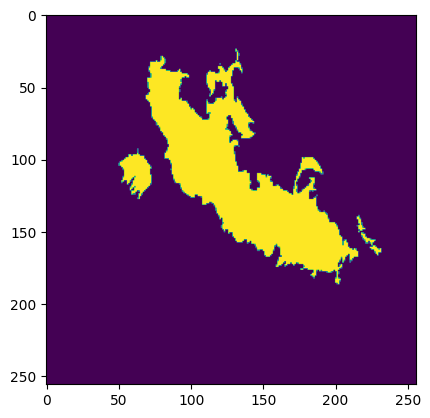

In [ ]:
plt.imshow(train_data[0]["labels"])

In [ ]:
def generator_train():
    for datapoint in train_data:
        yield datapoint

def generator_valid():
    for datapoint in valid_data:
        yield datapoint

def generator_test():
    for datapoint in test_data:
        yield datapoint

### Using `tf.data.Dataset` to build input pipeline

In [ ]:
batch_size = 4
auto = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(generator_train, output_types={"pixel_values": tf.float32, "labels": tf.int32}).cache().shuffle(batch_size * 10).batch(batch_size).prefetch(auto)

valid_ds = tf.data.Dataset.from_generator(generator_valid, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)

test_ds = tf.data.Dataset.from_generator(generator_test, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)

In [ ]:
print(train_ds.element_spec)


{'pixel_values': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), 'labels': TensorSpec(shape=<unknown>, dtype=tf.int32, name=None)}


# Visualizing the data

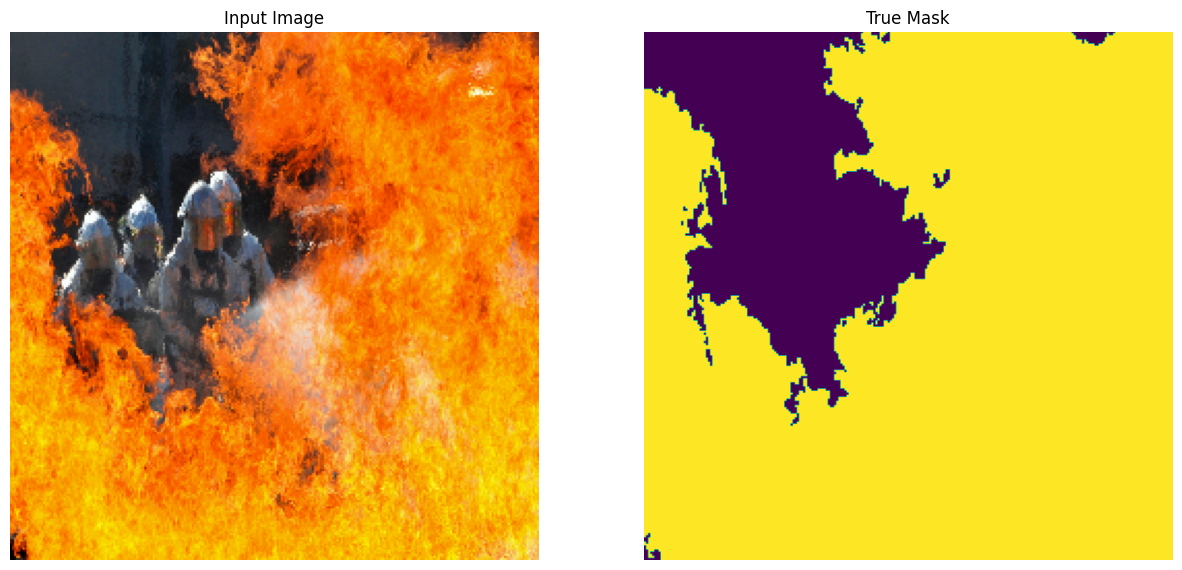

(256, 256, 3)


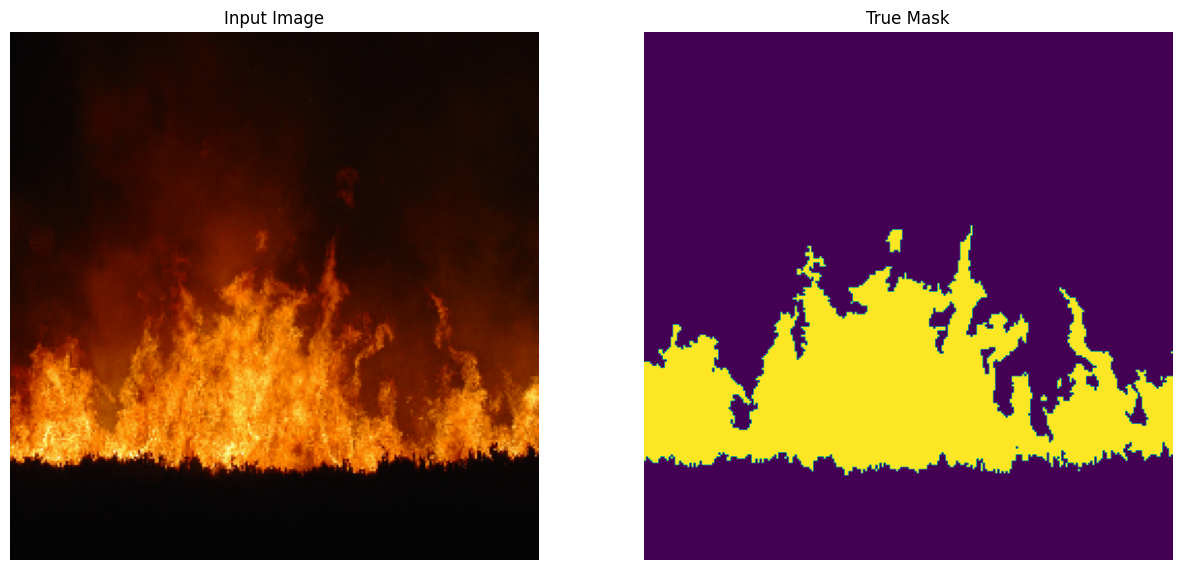

(256, 256, 3)


In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]

    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])
    print(sample_image.shape)

### Model

In [ ]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b1"
id2label =  {0: "outer", 1: "landslide"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,

)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b1 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Hyperparameters and compiling the model

In [ ]:
lr = 0.00006
epochs = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

#### Callback to visualize image after every epoch

In [ ]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

### Training Loop

1/1 [==============================] - 0s 54ms/step


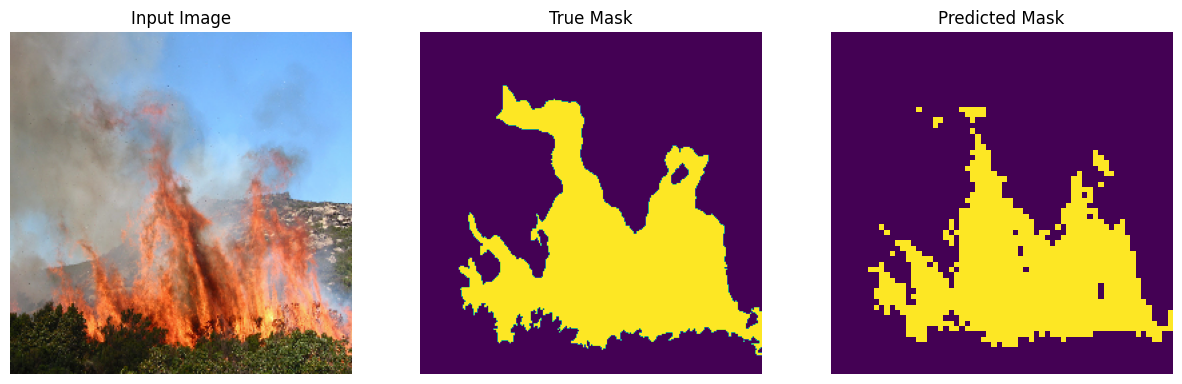


Sample Prediction after epoch 10

111/111 [==============================] - 14s 127ms/step - loss: 0.0563 - val_loss: 0.0624


In [ ]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs=epochs,
)

#### Loss Plot

<ipython-input-19-2df983d90a25>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


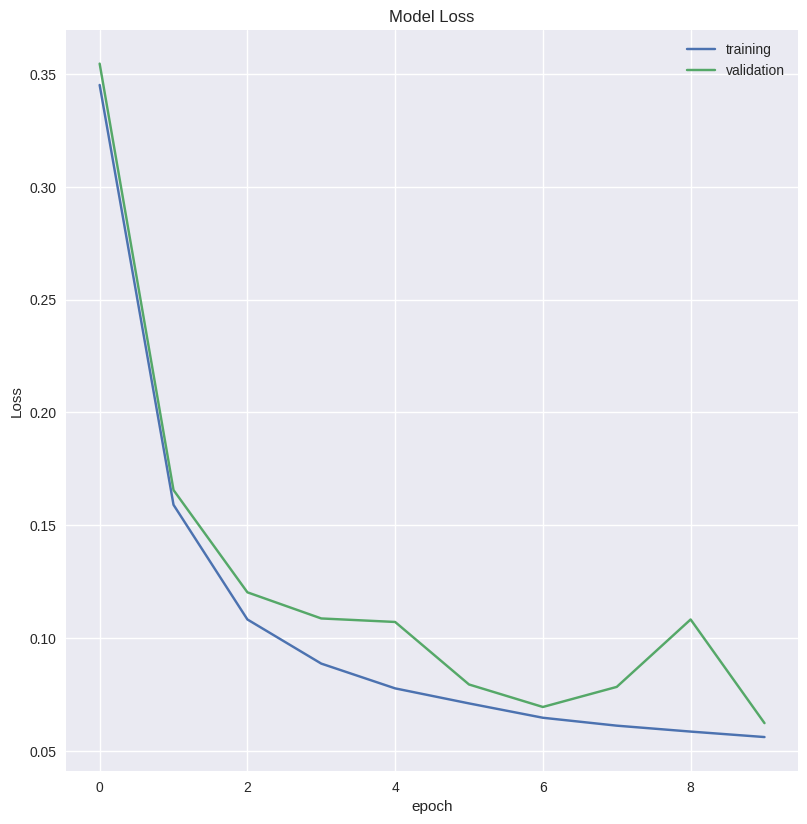

In [ ]:
plt.style.use("seaborn")

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(8,8))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 111)
plt.savefig("train_eval_plot_segformer-5-b1.jpg")

### Predictions

1/1 [==============================] - 0s 52ms/step


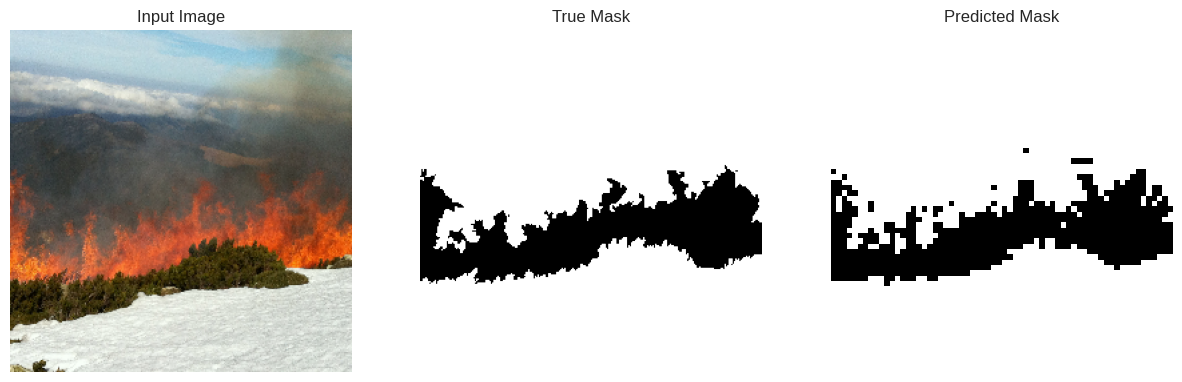

1/1 [==============================] - 0s 53ms/step


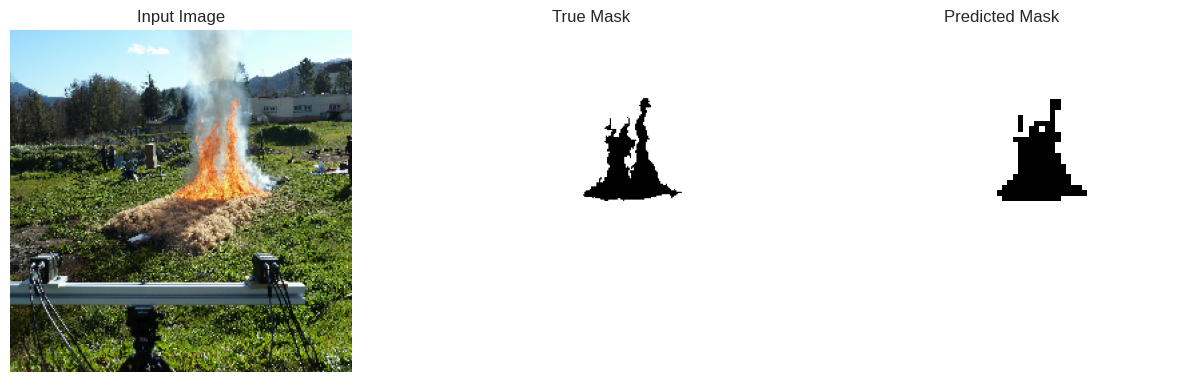

1/1 [==============================] - 0s 88ms/step


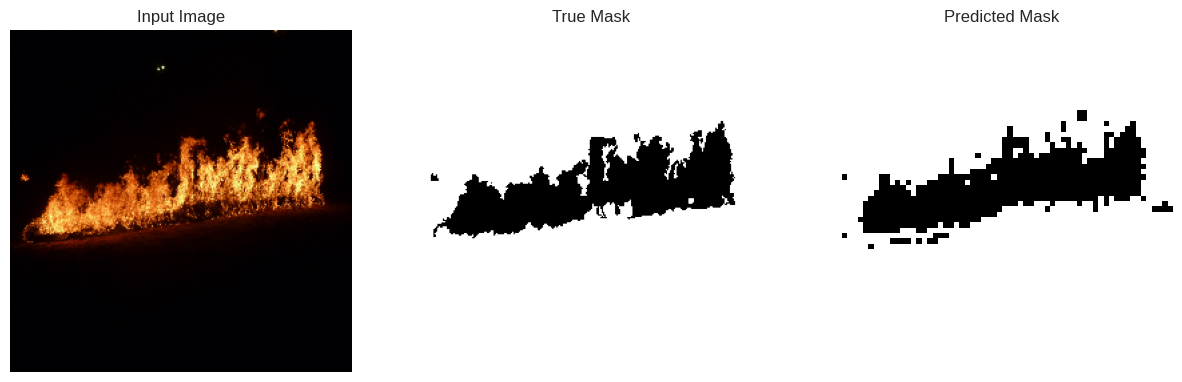

1/1 [==============================] - 0s 68ms/step


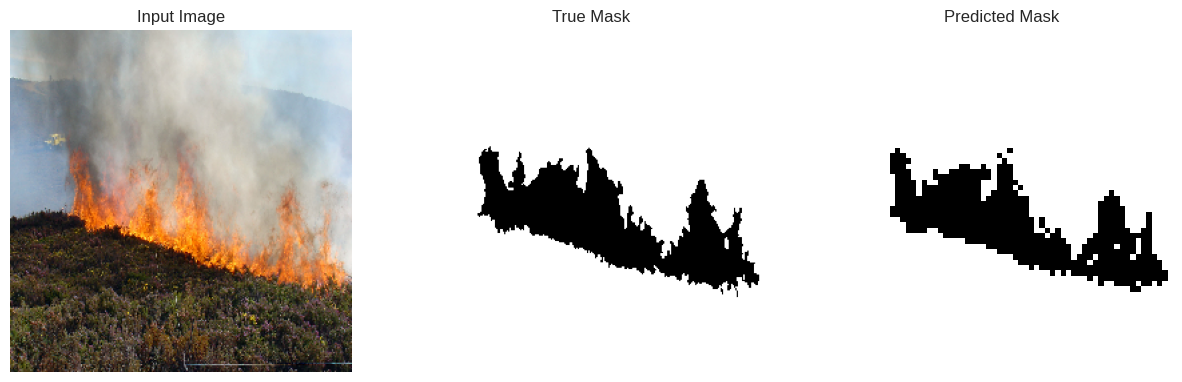

1/1 [==============================] - 0s 74ms/step


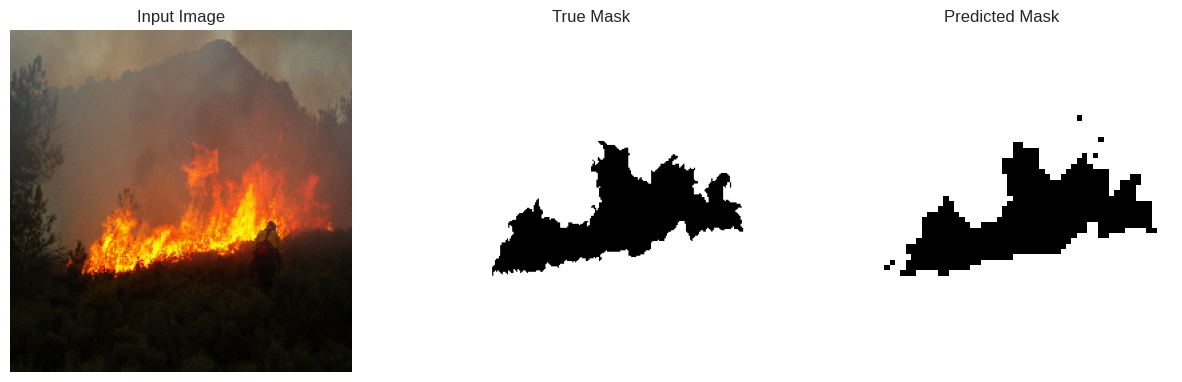

1/1 [==============================] - 0s 70ms/step


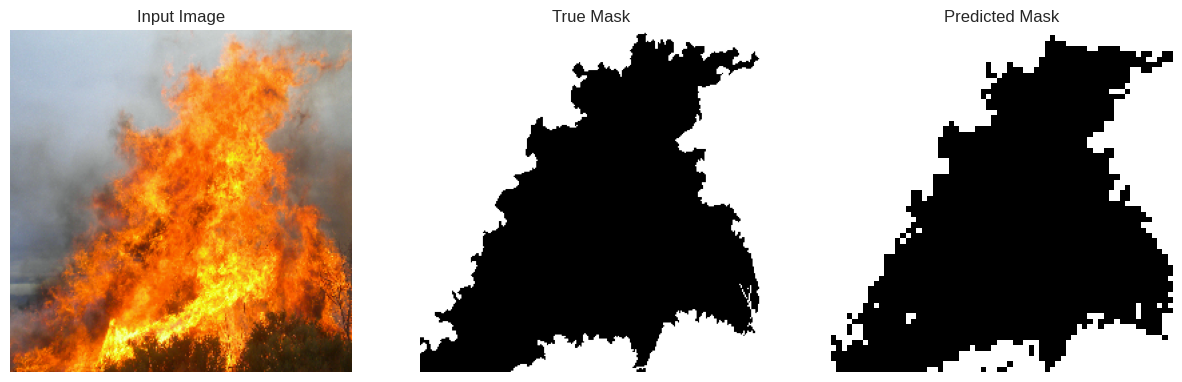

1/1 [==============================] - 0s 81ms/step


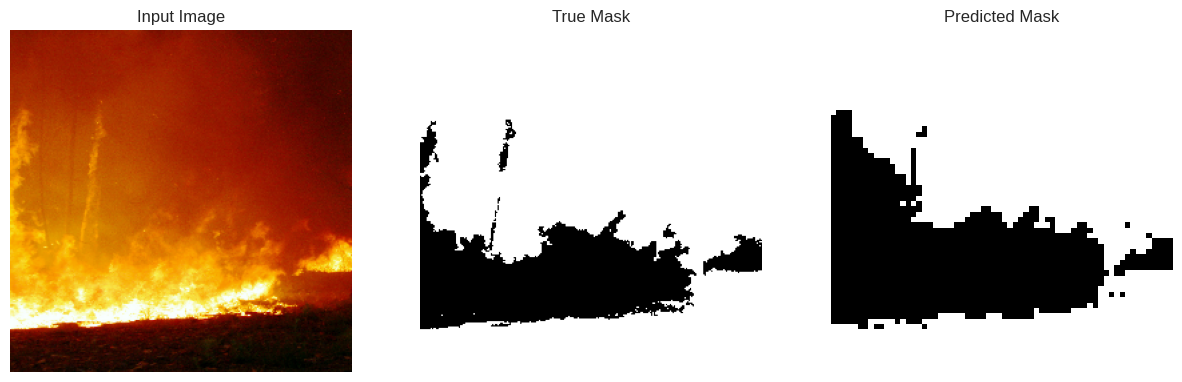

1/1 [==============================] - 0s 76ms/step


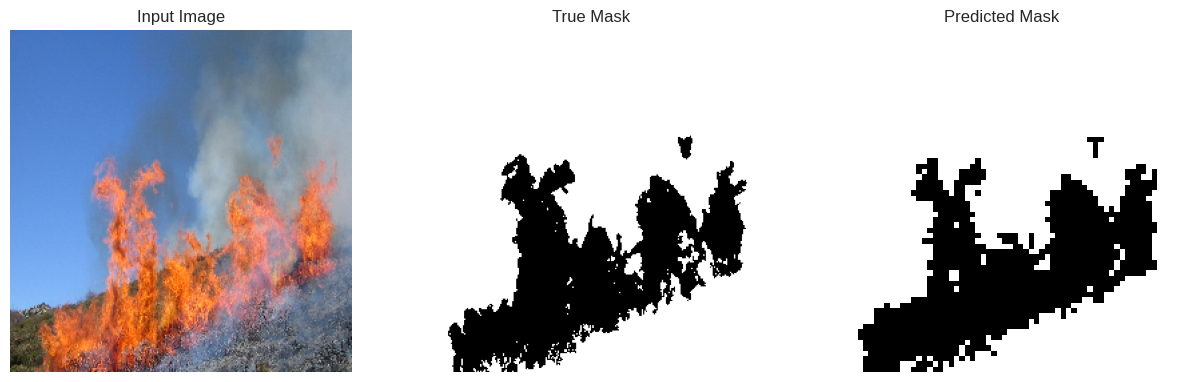

1/1 [==============================] - 0s 78ms/step


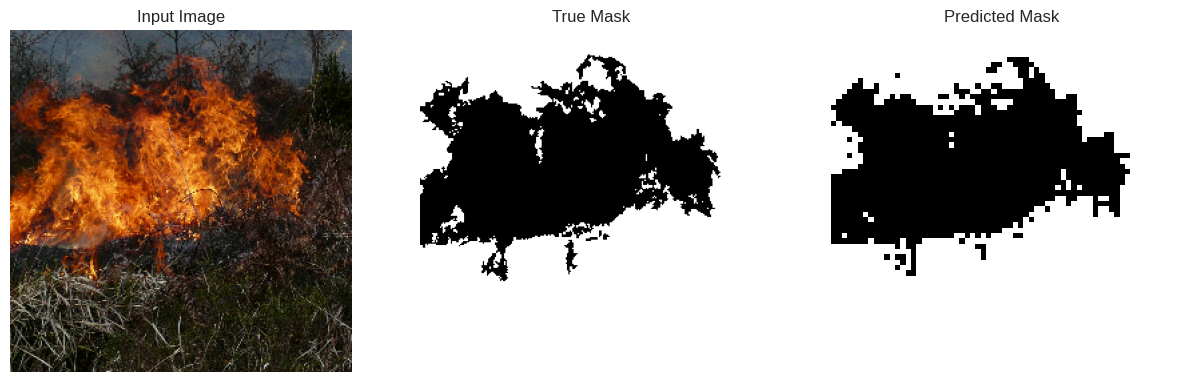

1/1 [==============================] - 0s 74ms/step


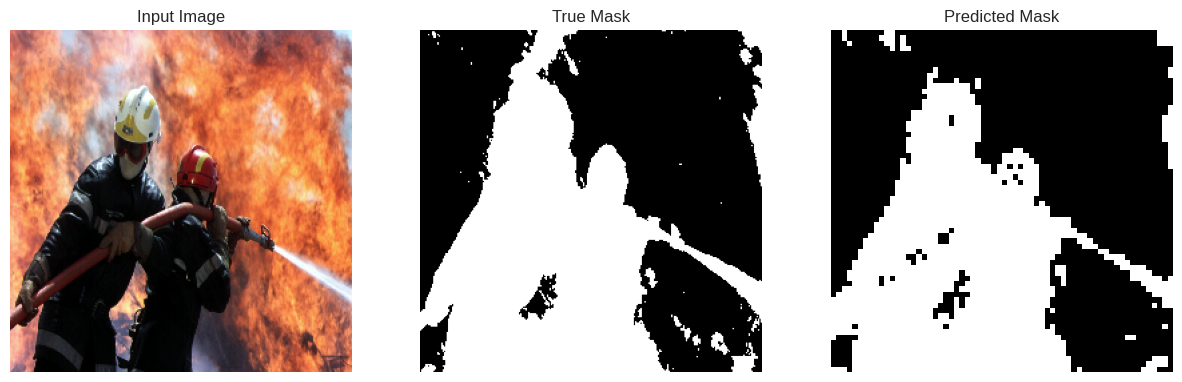

In [ ]:
show_predictions(valid_ds, 10)

In [ ]:
!pip install torchmetrics
!pip install PIL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 2.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [ ]:
# F1 block
import torchmetrics
from torchmetrics.classification import BinaryF1Score
import torch
from torch import tensor
import numpy as np
from PIL import Image

all_preds = []
all_masks = []

for sample in test_ds:
  images, masks = sample["pixel_values"], sample["labels"]
  masks = tf.expand_dims(masks, -1)
  pred_masks = model.predict(images).logits
  images = tf.transpose(images, (0, 2, 3, 1))


  # Resize predictions to match the size of target masks
  pred_masks_resized = torch.nn.functional.interpolate(tensor(pred_masks), size=(256, 256), mode='nearest')

  # all_masks.append(masks[0])
  # all_preds.append(create_mask(pred_masks))

  all_masks.append(masks[0])
  all_preds.append(create_mask(pred_masks_resized))

preds = np.array(all_preds)
masks = np.array(all_masks)

print(preds.shape)

# converting preds and mask to binary masks (all non-zero values converted to 1)
preds[preds > 0] = 1
masks[masks > 0] = 1

# print(all_preds)
# pytorch f1
metric = BinaryF1Score()
print("F1 Score Using PyTorch: ", metric(tensor(masks), tensor(preds)).item())


# custom f1
def f1_cal(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    f1 = np.mean(2*intersect/total_sum)
    return f1

print("F1 Score Using Custom Function: ", f1_cal(masks, preds))

1/1 [==============================] - 3s 3s/step
(15, 256, 256, 1)
F1 Score Using PyTorch:  0.9167134761810303
F1 Score Using Custom Function:  0.9167134968150267
